Training: 100%|██████████| 10000/10000 [28:07<00:00,  5.93episode/s, Avg Reward (last 10 episodes)=3.08e+3]


Rewards history saved
Saved policy for agent_0 to agent_0_policy_lstm.pth
Saved policy for agent_1 to agent_1_policy_lstm.pth
Saved policy for agent_2 to agent_2_policy_lstm.pth
Saved policy for agent_3 to agent_3_policy_lstm.pth
Saved policy for agent_4 to agent_4_policy_lstm.pth


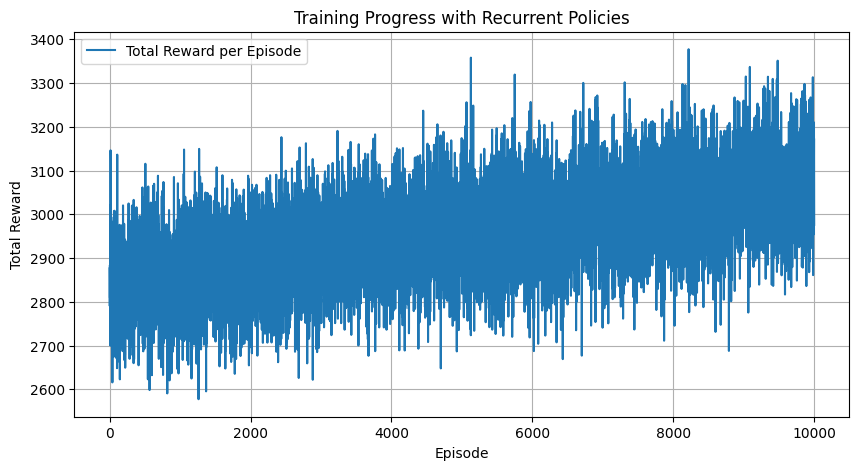

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Recurrent 策略网络
# ------------------------------------------------------------
class RecurrentPolicy(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(RecurrentPolicy, self).__init__()
        self.hidden_size = hidden_size
        # 这里设置 batch_first=True，输入输出将是 (batch, seq_len, input_size)
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x, h_c):
        """
        x 的预期维度: (batch_size, seq_len, input_dim)
        h_c 为 (h0, c0)，它们的维度都是 (num_layers, batch_size, hidden_size)，
        这里我们只用1层LSTM，因此 num_layers=1。

        返回:
          logits: (batch_size, seq_len, output_dim)
          (hn, cn): 更新后的隐藏状态
        """
        out, (hn, cn) = self.lstm(x, h_c)   # out: (batch_size, seq_len, hidden_size)
        logits = self.fc(out)              # (batch_size, seq_len, output_dim)
        return logits, (hn, cn)

    def init_hidden(self, batch_size=1):
        """
        初始化隐藏状态和细胞状态 (h0, c0) 维度:
          (1, batch_size, hidden_size)
        """
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))


# ------------------------------------------------------------
# 训练函数：使用 REINFORCE，并把模型改成 RecurrentPolicy
# ------------------------------------------------------------
def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=6500, hidden_size=64):
    # 取环境中的智能体列表
    agents = env.agents

    # 为每个agent建立独立的循环策略网络和优化器
    policies = {}
    optimizers = {}
    for agent in agents:
        obs_dim = env.observation_space(agent).shape[0]
        act_space = env.action_space(agent).n
        policy = RecurrentPolicy(obs_dim, hidden_size, act_space)
        policies[agent] = policy
        optimizers[agent] = optim.Adam(policy.parameters(), lr=lr)

    # 记录所有回合的总奖励
    total_rewards_history = []

    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")
    for episode in progress_bar:
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False

        # 为了在一次前向传播里处理整个序列，需要把每个时间步的状态都存下来
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}

        # ------------------------------
        # 在环境中执行一回合
        # ------------------------------
        while not done_flag:
            actions = {}
            for agent in agents:
                # 这里先用“前馈”的方式选动作（为简单起见，每个时间步都单独forward也行，
                # 但这个 forward 不会参与梯度回传，仅用于选动作）
                # 让网络暂时以 (batch=1, seq_len=1, input_dim) 的输入来做一次推理
                policy = policies[agent]
                obs_tensor = torch.FloatTensor(obs[agent]).view(1, 1, -1)  # shape: (1, 1, obs_dim)
                
                # 对于选动作，我们可以使用一个“瞬时初始化的”隐状态(不跟随时间累积)，
                # 仅为了拿到当前 logits。也可以改进为在执行时保留隐藏态。
                h0, c0 = policy.init_hidden(batch_size=1)
                with torch.no_grad():
                    logits, _ = policy(obs_tensor, (h0, c0))  # logits: (1, 1, act_space)
                probs = torch.softmax(logits[:, -1, :], dim=-1)  # 取最后一个时间步做 softmax
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action

            # 与环境交互
            next_obs, rewards, dones, infos = env.step(actions)

            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])

            obs = next_obs
            done_flag = all(dones.values())

        # ------------------------------
        # 回合结束，开始计算回报并更新策略
        # ------------------------------
        for agent in agents:
            # 计算每个时间步的回报 G
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)

            returns = np.array(returns, dtype=np.float32)
            obs_seq = np.array(trajectories[agent]["obs"], dtype=np.float32)   # shape: (T, obs_dim)
            actions_seq = np.array(trajectories[agent]["actions"], dtype=np.int64)  # shape: (T, )

            # 转换成张量（加上 batch 维度=1）
            obs_tensor = torch.FloatTensor(obs_seq).unsqueeze(0)      # (1, T, obs_dim)
            actions_tensor = torch.LongTensor(actions_seq).unsqueeze(0)   # (1, T)
            returns_tensor = torch.FloatTensor(returns).unsqueeze(0)      # (1, T)

            # 前向传播得到整个序列的 logits
            policy = policies[agent]
            optimizer = optimizers[agent]
            h0, c0 = policy.init_hidden(batch_size=1)

            logits, _ = policy(obs_tensor, (h0, c0))   # logits: (1, T, act_space)
            log_probs = torch.log_softmax(logits, dim=-1)  # (1, T, act_space)

            # 根据 actions_tensor 来取对应动作的 log_probs
            # actions_tensor 是 shape (1, T)，可以用 gather:
            # chosen_log_probs shape = (1, T)
            chosen_log_probs = log_probs.gather(2, actions_tensor.unsqueeze(-1)).squeeze(-1)

            # 计算 REINFORCE 的损失
            loss = -(chosen_log_probs * returns_tensor).mean()

            # 反向传播并更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ------------------------------
        # 记录并打印本回合总奖励
        # ------------------------------
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)

        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})

        # 如果想设定一个阈值来提前停止训练，可以这样做
        if total_reward_this_episode >= reward_threshold:
            # 打印本回合各个时间步动作（可选）
            for t in range(len(trajectories[agents[0]]["actions"])):
                step_action = [trajectories[agent]["actions"][t] for agent in agents]
                print(step_action)
            print("=======!!!!!!!!!!!!!!!=======")
            break

    return total_rewards_history, policies

from env_new.MAenv_3 import CustomMAEnvironment3
# ------------------------------------------------------------
# 以下为与环境的结合示例：读取环境（自定义环境请自行import或定义）
# ------------------------------------------------------------
if __name__ == "__main__":
    # 假设环境已定义好并从别处 import
    # from env_new.MAenv_3 import CustomMAEnvironment3
    # 创建环境
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)

    # 开始训练
    rewards_history, policies = train_multiagent(
        env, 
        num_episodes=10000, 
        gamma=0.99, 
        lr=0.001,
        hidden_size=64,        # LSTM 隐藏层大小
        reward_threshold=6500
    )

    # 保存训练曲线
    np.save("rewards_history_lstm.npy", rewards_history)
    print("Rewards history saved")

    # 保存每个智能体的策略
    for agent, policy in policies.items():
        torch.save(policy.state_dict(), f"{agent}_policy_lstm.pth")
        print(f"Saved policy for {agent} to {agent}_policy_lstm.pth")

    # 绘制总回报曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress with Recurrent Policies")
    plt.legend()
    plt.grid(True)
    plt.show()

Rewards history loaded successfully.
Top 1: Reward = 3377.32, Step = 8217
Top 2: Reward = 3358.04, Step = 5127
Top 3: Reward = 3351.12, Step = 9481
Top 4: Reward = 3336.84, Step = 9086
Top 5: Reward = 3319.4000000000005, Step = 5749
Top 6: Reward = 3314.9399999999996, Step = 9029
Top 7: Reward = 3314.46, Step = 9343
Top 8: Reward = 3313.26, Step = 9980
Top 9: Reward = 3309.48, Step = 9411
Top 10: Reward = 3307.96, Step = 9469


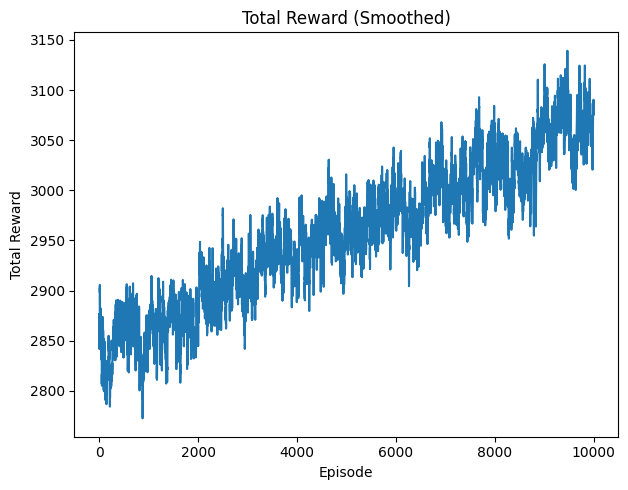

In [6]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history_lstm.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()
